In [1]:
# import libraries
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append("../")
sys.path.append("../../")

import os
import random
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

from open_data import open_data, create_global_batch
from dataset import RadarDataset,RadarCollate
from simple_model import LSTM
from train import train

In [3]:
PATH_CSV="/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'

In [4]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [5]:
batch_df=create_global_batch(df1, window_x_day=6, window_label_day=1, gap_acquisition=1, tot_len_day=365)

Building batch 0 
 x begin 2018-01-02 label begin 2018-01-08 end period 2018-12-23 
Building batch 1 
 x begin 2018-01-03 label begin 2018-01-09 end period 2018-12-23 
Building batch 2 
 x begin 2018-01-04 label begin 2018-01-10 end period 2018-12-23 
Building batch 3 
 x begin 2018-01-05 label begin 2018-01-11 end period 2018-12-23 
Building batch 4 
 x begin 2018-01-06 label begin 2018-01-12 end period 2018-12-23 
We do not have all the dates for the time period in label , 96 42
Building batch 4 
 x begin 2018-01-07 label begin 2018-01-13 end period 2018-12-23 
Building batch 4 
 x begin 2018-01-08 label begin 2018-01-14 end period 2018-12-23 
Building batch 4 
 x begin 2018-01-09 label begin 2018-01-15 end period 2018-12-23 
Building batch 4 
 x begin 2018-01-10 label begin 2018-01-16 end period 2018-12-23 
Building batch 4 
 x begin 2018-01-11 label begin 2018-01-17 end period 2018-12-23 
Building batch 4 
 x begin 2018-01-12 label begin 2018-01-18 end period 2018-12-23 
Building b

In [6]:
batch_df

,vol_data_x,vol_label_y
0,"[22, 13, 21, 21, 15, 11, 19, 5, 14, 6, 5, 8, 4...","[24.0, 21.0, 0.0, 0.0, 18.0, 10.0, 14.0, 10.0,..."
1,"[33.0, 31.0, 20.0, 22.0, 13.0, 13.0, 13.0, 9.0...","[66, 40, 40, 22, 28, 22, 13, 9, 10, 14, 17, 7,..."
2,"[32.0, 31.0, 25.0, 29.0, 29.0, 10.0, 21.0, 17....","[36, 32, 28, 26, 23, 20, 14, 21, 8, 9, 11, 9, ..."
3,"[33.0, 37.0, 28.0, 19.0, 26.0, 16.0, 13.0, 14....","[48, 32, 36, 28, 32, 23, 8, 22, 17, 7, 21, 15,..."
4,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[33, 38, 45, 30, 25, 10, 13, 15, 4, 8, 4, 9, 1..."
...,...,...
202,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ..."
203,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,..."
204,"[70, 63, 57, 46, 38, 33, 25, 30, 24, 16, 10, 1...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ..."
205,"[87, 78, 75, 57, 45, 31, 35, 28, 26, 15, 10, 1...","[82, 87, 67, 69, 46, 32, 40, 27, 23, 19, 23, 1..."


In [7]:
#batch_df["mean_x"]=batch_df["vol_data_x"].apply(lambda x : np.mean(x))
#batch_df["std_x"]=batch_df["vol_data_x"].apply(lambda x : np.std(x))
#batch_df["mean_y"]=batch_df["vol_label_y"].apply(lambda x : np.mean(x))
# batch_df

In [8]:
def get_df_stats(df,columns=None):
    """ return mean and std for the columns"""
    if columns is None: 
        columns=["vol_data_x","vol_label_y"]
    dic={}
    global_mean=0
    global_std=0
    for name in columns:
        df["{}_min".format(name)]=df[name].apply(lambda x : np.min(x))
        df["{}_max".format(name)]=df[name].apply(lambda x : np.max(x))
        global_mean+=df["{}_min".format(name)].min()
        global_std+=df["{}_max".format(name)].max()
    return global_mean/len(columns),global_std/len(columns)
    
def apply_norm(df,mini,maxi,columns=None):
    """ apply std"""
    if columns is None: 
        columns=["vol_data_x","vol_label_y"]
    for name in columns:
        df["{}_norm".format(name)]=df[name].apply(lambda x : (x-mini)/(maxi-mini))
    return df

In [9]:
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)


In [10]:
get_df_stats(new_data,["vol_data_x_norm","vol_label_y_norm"])

(0.0, 1.0)

In [11]:
new_data

,vol_data_x,vol_label_y,vol_data_x_min,vol_data_x_max,vol_label_y_min,vol_label_y_max,vol_data_x_norm,vol_label_y_norm,vol_data_x_norm_min,vol_data_x_norm_max,vol_label_y_norm_min,vol_label_y_norm_max
0,"[22, 13, 21, 21, 15, 11, 19, 5, 14, 6, 5, 8, 4...","[24.0, 21.0, 0.0, 0.0, 18.0, 10.0, 14.0, 10.0,...",3.0,870.0,0.0,483.0,"[0.022610483042137718, 0.013360739979445015, 0...","[0.024665981500513873, 0.02158273381294964, 0....",0.003083,0.894142,0.000000,0.496403
1,"[33.0, 31.0, 20.0, 22.0, 13.0, 13.0, 13.0, 9.0...","[66, 40, 40, 22, 28, 22, 13, 9, 10, 14, 17, 7,...",0.0,870.0,4.0,474.0,"[0.03391572456320658, 0.03186022610483042, 0.0...","[0.06783144912641316, 0.041109969167523124, 0....",0.000000,0.894142,0.004111,0.487153
2,"[32.0, 31.0, 25.0, 29.0, 29.0, 10.0, 21.0, 17....","[36, 32, 28, 26, 23, 20, 14, 21, 8, 9, 11, 9, ...",0.0,870.0,2.0,470.0,"[0.0328879753340185, 0.03186022610483042, 0.02...","[0.03699897225077081, 0.0328879753340185, 0.02...",0.000000,0.894142,0.002055,0.483042
3,"[33.0, 37.0, 28.0, 19.0, 26.0, 16.0, 13.0, 14....","[48, 32, 36, 28, 32, 23, 8, 22, 17, 7, 21, 15,...",0.0,483.0,5.0,477.0,"[0.03391572456320658, 0.03802672147995889, 0.0...","[0.04933196300102775, 0.0328879753340185, 0.03...",0.000000,0.496403,0.005139,0.490236
4,"[13.0, 5.0, 14.0, 15.0, 9.0, 4.0, 6.0, 1.0, 4....","[33, 38, 45, 30, 25, 10, 13, 15, 4, 8, 4, 9, 1...",0.0,789.0,4.0,492.0,"[0.013360739979445015, 0.0051387461459403904, ...","[0.03391572456320658, 0.03905447070914697, 0.0...",0.000000,0.810894,0.004111,0.505653
...,...,...,...,...,...,...,...,...,...,...,...,...
202,"[58, 28, 26, 33, 20, 23, 13, 15, 6, 7, 13, 5, ...","[38, 35, 29, 18, 11, 20, 11, 14, 9, 13, 6, 7, ...",3.0,488.0,4.0,484.0,"[0.05960945529290853, 0.02877697841726619, 0.0...","[0.03905447070914697, 0.03597122302158273, 0.0...",0.003083,0.501542,0.004111,0.497431
203,"[50, 40, 36, 22, 27, 22, 19, 27, 15, 12, 7, 9,...","[41, 42, 32, 32, 20, 13, 22, 15, 10, 8, 5, 11,...",3.0,488.0,5.0,501.0,"[0.051387461459403906, 0.041109969167523124, 0...","[0.0421377183967112, 0.04316546762589928, 0.03...",0.003083,0.501542,0.005139,0.514902
204,"[70, 63, 57, 46, 38, 33, 25, 30, 24, 16, 10, 1...","[63, 52, 39, 29, 25, 17, 19, 18, 10, 8, 6, 9, ...",3.0,501.0,6.0,480.0,"[0.07194244604316546, 0.06474820143884892, 0.0...","[0.06474820143884892, 0.05344295991778006, 0.0...",0.003083,0.514902,0.006166,0.493320
205,"[87, 78, 75, 57, 45, 31, 35, 28, 26, 15, 10, 1...","[82, 87, 67, 69, 46, 32, 40, 27, 23, 19, 23, 1...",3.0,501.0,5.0,409.0,"[0.08941418293936279, 0.08016443987667009, 0.0...","[0.0842754367934224, 0.08941418293936279, 0.06...",0.003083,0.514902,0.005139,0.420349


In [12]:
#get_df_stats(new_data,columns=["vol_data_x_norm","vol_label_y_norm"])

In [13]:
# sample_rate = 16000
batch_size = 1

In [14]:
normalize=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[df_mean],
                         std=[df_std])
])
fullset = RadarDataset(dataframe=batch_df,transform=None)

ptrain,pval,ptest=0.8,0.05,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest))

(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,

In [15]:
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [16]:
c= 0
for x in trainloader:
    print("batch number {}".format(c))
    print(x[0].shape, x[1].shape, "\n")
    #print(x)
    c+=1

batch number 0
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 1
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 2
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 3
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 4
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 5
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 6
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 7
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 8
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 9
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 10
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 11
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 12
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 13
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 14
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 15
torch.Size([1, 576]) torch.Size([1, 96]) 

batch number 16
torch.Size([1, 576]) torch.Size([1, 96]) 

batch n

## Modèle 1 

In [17]:
input_dim = 576    
hidden_dim = 256
layer_dim = 2
output_dim = 96
seq_dim = 1

lr = 0.05
n_epochs = 100
iterations_per_epoch = len(trainloader)
name_model = "model1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model=LSTM()


In [18]:
iteration,loss_train_list,loss_val_list=train(model, trainloader, valloader, lr=lr, n_epochs=n_epochs, name_model=name_model, device=device, ite_print=5)

/Users/clemencevast/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 8.549608173780143e-05 loss val 0.001977434614673257
tensor(0.0024) 20.0
epoch 6 loss train 1.1016503549399204e-06 loss val 5.381385926739313e-05
tensor(6.2294e-05) tensor(0.0024)
epoch 11 loss train 3.3126354992418783e-06 loss val 6.668534751952393e-06
tensor(8.7513e-06) tensor(6.2294e-05)
epoch 16 loss train 8.767667623033049e-07 loss val 1.2736199096252676e-05
tensor(1.5398e-05) tensor(8.7513e-06)
epoch 21 loss train 8.197825422939786e-07 loss val 8.492271263094153e-06
tensor(1.0350e-05) tensor(8.7513e-06)
epoch 26 loss train 4.32302431363496e-06 loss val 7.586876563436817e-06
tensor(8.5936e-06) tensor(8.7513e-06)
epoch 31 loss train 1.8278031532759087e-08 loss val 7.724696843069978e-06
tensor(9.1149e-06) tensor(8.5936e-06)
epoch 36 loss train 4.054320754676155e-07 loss val 5.862962098035496e-06
tensor(6.8492e-06) tensor(8.5936e-06)
epoch 41 loss train 2.3661989416723372e-06 loss val 8.891136531019583e-06
tensor(9.9488e-06) tensor(6.8492e-06)
epoch 46 loss train 7.

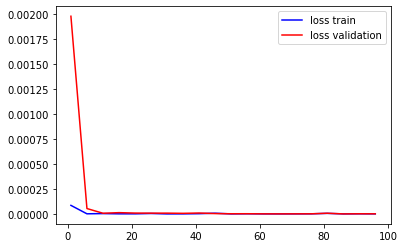

In [19]:
fig,ax=plt.subplots()
ax.plot(iteration,loss_train_list,"b",label="loss train")
ax.plot(iteration,loss_val_list,"r",label="loss validation")
ax.legend()

## Modèle 2 

In [20]:
input_dim = 576    
hidden_dim = 256
layer_dim = 2
output_dim = 96
seq_dim = 1

lr2 = 0.001
n_epochs = 100
iterations_per_epoch = len(trainloader)
name_model = "model2"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=LSTM()


In [21]:
iteration2,loss_train_list2,loss_val_list2=train(model, trainloader, valloader, lr=lr2, n_epochs=n_epochs, name_model=name_model, device=device,ite_print=2)

epoch 1 loss train 2.0663249244989856e-07 loss val 0.0011006828863173723
tensor(0.0013) 20.0
epoch 3 loss train 1.4920043156507745e-07 loss val 0.0011175523977726698
tensor(0.0013) tensor(0.0013)
epoch 5 loss train 1.2775449143020978e-08 loss val 0.001080199028365314
tensor(0.0013) tensor(0.0013)
epoch 7 loss train 7.598896445415448e-07 loss val 0.0011328193359076977
tensor(0.0013) tensor(0.0013)
epoch 9 loss train 8.715554855598384e-08 loss val 0.0010199346579611301
tensor(0.0012) tensor(0.0013)
epoch 11 loss train 9.866764827393126e-08 loss val 0.0010211202315986156
tensor(0.0012) tensor(0.0012)
epoch 13 loss train 1.0310770903743105e-07 loss val 0.0010114890756085515
tensor(0.0012) tensor(0.0012)
epoch 15 loss train 9.917139323079027e-07 loss val 0.0009638310875743628
tensor(0.0011) tensor(0.0012)
epoch 17 loss train 1.5920705891403486e-06 loss val 0.0008182341698557138
tensor(0.0010) tensor(0.0011)
epoch 19 loss train 3.1084667284630996e-07 loss val 0.0008314860751852393
tensor(0.0

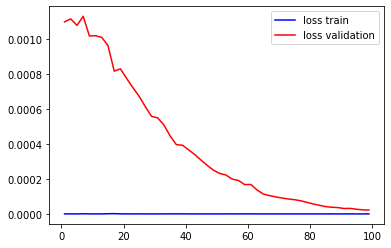

In [22]:
fig,ax=plt.subplots()
ax.plot(iteration2,loss_train_list2,"b",label="loss train")
ax.plot(iteration2,loss_val_list2,"r",label="loss validation")
ax.legend()